# Project

In [1]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
import tdmclient.notebook
await tdmclient.notebook.start()
#from tdmclient import ClientAsync, aw

In [2]:
# parametres
speed_r = 125
time_rotation = 7*speed_r/125

speed_f = 125
stop = 0

MIN_DIST = 30
ANGLE_TOLERANCE = 0.30

def motors_async(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }


@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    """
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

#input : angle to change the trajectory
@tdmclient.notebook.sync_var
def orientation (angle):  
 #   global motor_left_target, motor_right_target
    if(angle >= 0 ):
        motors(-speed_r, speed_r)
    else:
        motors(speed_r, -speed_r)
    #if angle < 0:
    #    motors(speed_r, stop)
    #else :
    #    motors(stop, speed_r)
    #    
    time.sleep(0.01)
    

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

#input : coordinates of two different points 
#return the distance between two points 
def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

In [3]:
def controller(goal_dist, angle):
    kp_rot = 100
    kp_lin = 3

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l = 80 - kp_rot*(angle)
        speed_r = 80 + kp_rot*(angle)

    else:
        speed_l = 150
        speed_r = 150

    motors(int(speed_l),int(speed_r))


In [4]:
def mouving (video_capture, path, x0, y0, theta0, periode=0.005):
    teta = np.zeros(np.shape(path)[0])
   
    goalx = path[0][0]
    goaly = path[0][1]
    
    i = 0
    x_pense = x0
    y_pense = y0
    teta_pense = theta0
    
    kx = 0
    ky = 0
    kteta = 0
    angle = 0
   
    print('x =', x_pense, 'y =', y_pense, 'teta =', teta_pense)
    dist = distance (goalx, goaly, kx, ky)
    while True:
        #[kx, ky, kteta] = kalman()
        
        ret, frame = video_capture.read()
        position_measure = []
        if ret == True:
            position_measure, position_contour,_ = computer_vision(frame, 'robot', False)
            if len(position_measure) == 1:
                position_measure = position_measure[0]
                if position_measure is not None:
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                position_measure = invert_coordinates(position_measure)
                [kx, ky, kteta] = [position_measure[0], position_measure[1], -theta_measure]
                dist = distance (goalx, goaly, kx, ky)
        
        teta[i] = math.atan2((goaly - ky), (goalx - kx)) #change angle according to kalman

        
        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
                #motors(speed_f, speed_f)            
                x_pense = path[i-1][0]
                y_pense = path[i-1][1]
                vec1 = [np.cos(teta[i-1]), np.sin(teta[i-1])]
                vec2 = [goalx - x_pense, goaly - y_pense]
                angle = get_angle_between(vec1, vec2)
                
                teta_pense = angle + teta[i-1]
            else:
                motors(stop, stop)
                break
        else :
            x_pense = kx + speed_f * periode * np.cos(teta[i]) #à update
            y_pense = ky + speed_f * periode * np.sin(teta[i])
            teta_pense = teta[i]
            #kteta = teta[i]
            angle =  wrap_angle((teta[i] - kteta) % (2*np.pi))
            
            #time.sleep(periode)

        controller(dist,angle)
        print(i, ret, dist, position_measure, angle, teta[i], kteta)
    motors(stop, stop)

# Main 

1
2
3
start = [ 50.4 362.4] goal = [899.2 564. ]
path = [[ 50.4 362.4]
 [259.2 456. ]
 [588.8 649.6]
 [676.  724. ]
 [869.6 547.2]
 [899.2 564. ]]
872.4127463534677


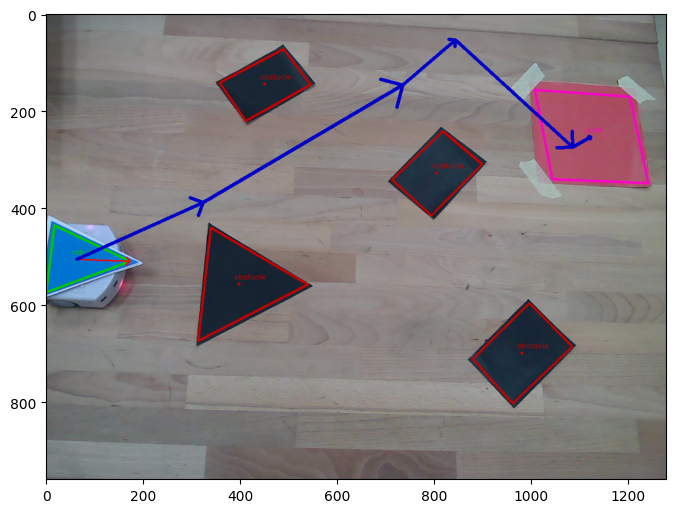

In [5]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
fig, ax = plt.subplots(figsize=(8,8))
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)


if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
    
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)
    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    

    print('start =', metric_start, 'goal =', metric_goal)
    print('path =', metric_path)

    print(distance(metric_start[0], metric_start[1], metric_goal[0], metric_goal[1]))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
#ret, frame = video_capture.read()
#print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#cv2.imwrite('frame.jpeg', frame)

motors(stop, stop)
np.shape(path)
print(np.shape(path)[0])

6


In [7]:
mouving(video_capture, path, robot[0], robot[1], robot[2], periode=0.005)
print("finished")
motors(stop, stop)

x = 63 y = 507 teta = 0.036347621019020664
1 True 1.0 [64, 453] 2.720173446701989 0.0 -0.027515989285454418
1 True 286.02447447727263 [63, 453] 0.4486851753433987 0.4214192068878042 -0.027265968455594463
1 True 286.02447447727263 [63, 453] 0.4577668279068249 0.4214192068878042 -0.036347621019020664
1 True 289.0069203323685 [58, 457] 0.283619396030908 0.401711424450002 0.11809202841909398
1 True 277.62204523416364 [67, 465] 0.1047683185687841 0.38786410386827963 0.28309578529949553
1 True 271.48664792214 [72, 469] 0.045742043764232077 0.3811903715337401 0.335448327769508
1 True 259.7883754135277 [83, 473] 0.011759473861967795 0.38265076267463016 0.37089128881266237
1 True 245.86174977006894 [96, 478] 0.014458548589519282 0.3835275159569918 0.3690689673674725
1 True 229.7063342618135 [111, 484] 0.02599391512599153 0.38373999559116223 0.3577460804651707
1 True 215.77998053572995 [124, 489] 0.023972493512770476 0.38480927654586117 0.3608367830330907
1 True 200.92784774639875 [138, 494] 0.0

IndexError: index 6 is out of bounds for axis 0 with size 6